In [1]:
%matplotlib notebook
%matplotlib notebook

In [2]:
import random
import time
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

class Ant:
	"""A single Ant"""
		
	def __init__(self, model):
		self.model = model
		self.x = 0
		self.y = 0
		self.has_food = 0
	
	def next_left(self):
		"""The (x, y) position of the Location the Ant 
		would move to if it moved forward left.
		"""
		if not self.has_food:
			return (self.x, self.y + 1)
		else:
			return (self.x, self.y - 1)
	
	def next_right(self):
		"""The (x, y) position of the Location the Ant 
		would move to if it moved forward right.
		"""
		if not self.has_food:
			return (self.x + 1, self.y)
		else:
			return (self.x - 1, self.y)
	
	def left_pheromone(self):
		"""The amount of pheromone in the Location that 
		the Ant	would move into if it moved forward left.
		"""
		return self.model.get_pheromone(self.next_left())
	
	def right_pheromone(self):
		"""The amount of pheromone in the Location that 
		the Ant	would move into if it moved forward right.
		"""
		return self.model.get_pheromone(self.next_right())
	
	def will_move(self):
		"""Whether or not this Ant will move this turn."""
		if self.model.at_capacity(self.next_left()) and \
			self.model.at_capacity(self.next_right()):
			return False
		p_l = self.left_pheromone()
		p_r = self.right_pheromone()
		prob_move = 0.5 + 0.5*math.tanh((p_l + p_r) / 100.0 - 1)
		return random.random() < prob_move

	def will_go_right(self):
		"""Whether or not this Ant will move forward right
		this turn.
		"""
		p_l = self.left_pheromone()
		p_r = self.right_pheromone()

		if self.model.at_capacity(self.next_right()):
			return False

		if self.model.at_capacity(self.next_left()):
			return True

		prob_right = (1 - (5 + p_l)**2 / 
			      float((5 + p_l)**2 + (5 + p_r)**2))

		return random.random() < prob_right
		
	def move(self):
		"""Moves this Ant."""
		if not self.will_move(): 
			return
		if self.will_go_right():
			(self.x, self.y) = self.next_right()
		else:
			(self.x, self.y) = self.next_left()
		self.lay_pheromone()
		pos = (self.x, self.y)
		if pos == (0, 0):
			self.has_food = False
		else:
			if self.model.has_food(pos) and not self.has_food:
				self.model.remove_food(pos)
				self.has_food = True

	def lay_pheromone(self):
		"""This Ant lays pheromone in its current Location."""
		pos = (self.x, self.y)
		current = self.model.get_pheromone(pos)
		if not self.has_food:
			limit = 1000
			amount = 1
		else:
			limit = 300
			amount = 10
		if current >= limit: 
			return
		new_amount = min(current + amount, limit)
		self.model.set_pheromone(pos, new_amount)

In [3]:
class Location:
	"""The grid recording the food and pheromone."""
	
	def __init__(self):
		self.food = 0
		self.pheromone = 0
		
	def place_food(self, p):
		"""Place food with probability p into this Location."""
		if random.random() < p:
			self.food = 1

	def has_food(self):
		"""Returns True if this Location has at least 1 food in it,
		False otherwise.
		"""
		return self.food > 0
	
	def remove_food(self):
		"""Remove one food from this Location. Crashes if there is
		no food in this Location.
		"""
		assert(self.has_food)
		self.food -= 1
	
	def add_pheromone(self, amount=1):
		"""Add pheromone to this Location."""
		self.pheromone += amount
	
	def set_pheromone(self, amount):
		"""Set the pheromone in this Location to amount."""
		self.pheromone = amount
	
	def get_pheromone(self):
		"""Returns the amount of pheromone in this Location."""
		return self.pheromone
		
	def evaporate_pheromone(self):
		"""Evaporates 1/30 of the pheromone in this Location."""
		self.pheromone -= self.pheromone * (1.0 / 30)
	

class Model:
	"""Class that represents the room the robot ants live in	"""
	
	MAX_ANTS = 200
	
	def __init__(self):
		self.ants = {}
		self.locations = {}
		self.p_food = 0
	
	def place_food(self, p):
		"""Place food in all Locations with probability p."""
		self.p_food = p
		for point in self.locations:
			point.place_food(p)
	
	def remove_food(self, pos):
		"""Remove one unit of food from the Location at pos."""
		self.locations[pos].remove_food();
	
	def has_food(self, pos):
		"""Returns true if the Location at pos has at least one unit
		of food, false otherwise.
		"""
		return self.get_location(pos).has_food();
	
	def add_ants(self, n):
		"""Add n ants to the nest. Each ant starts at (0,0)"""
		for i in range(n):
			ant = Ant(self)
			pos = (ant.x, ant.y) 
			if pos in self.ants:
				self.ants[pos].append(ant)
			else:
				self.ants[pos] = [ant]
	
	def __repr__(self):
		"""Return a string representation of this room."""
		return str(self.ants)
	
	def move_ants(self):
		"""Iterate through and move all the Ants in the room."""
		ants = []
		for pos, antlist in self.ants.items():
			for ant in antlist:
				ant.move()
				ants.append(ant)
		self.evaporate_pheromone()
		d = {}
		for ant in ants:
			pos = (ant.x, ant.y)
			if pos in d:
				d[pos].append(ant)
			else:
				d[pos] = [ant]
		self.ants = d
	
	def get_location(self, pos):
		"""Returns the Location at pos, creating it if it doesn't 
		already exist.
		"""
		if pos not in self.locations:
			loc = Location()
			self.locations[pos] = loc
			if self.p_food > 0:
				loc.place_food(self.p_food)
		else: 
			loc = self.locations[pos]
		return loc
	
	def add_pheromone(self, pos, amount=1):
		"""Adds amount pheromone to the Location at pos."""
		self.get_location(pos).add_pheromone(amount)
	
	def get_pheromone(self, pos):
		"""Returns the amount of pheromone in the Location at pos."""
		return self.get_location(pos).get_pheromone();
	
	def set_pheromone(self, pos, amount):
		"""Sets the amount of pheromone in the Location at pos to
		amount.
		"""
		self.get_location(pos).set_pheromone(amount)
	
	def evaporate_pheromone(self):
		"""Evaporates pheromone from all existing Locations."""
		for pos, loc in self.locations.items():
			loc.evaporate_pheromone()
	
	def num_ants(self, pos):
		"""Returns the number of Ants at pos."""
		if pos in self.ants:
			return len(self.ants[pos])
		else: return 0

	def at_capacity(self, pos):
		"""Returns True if the Location at pos is full with Ants,
		False otherwise.
		"""
		return self.num_ants(pos) >= Model.MAX_ANTS

<IPython.core.display.Javascript object>


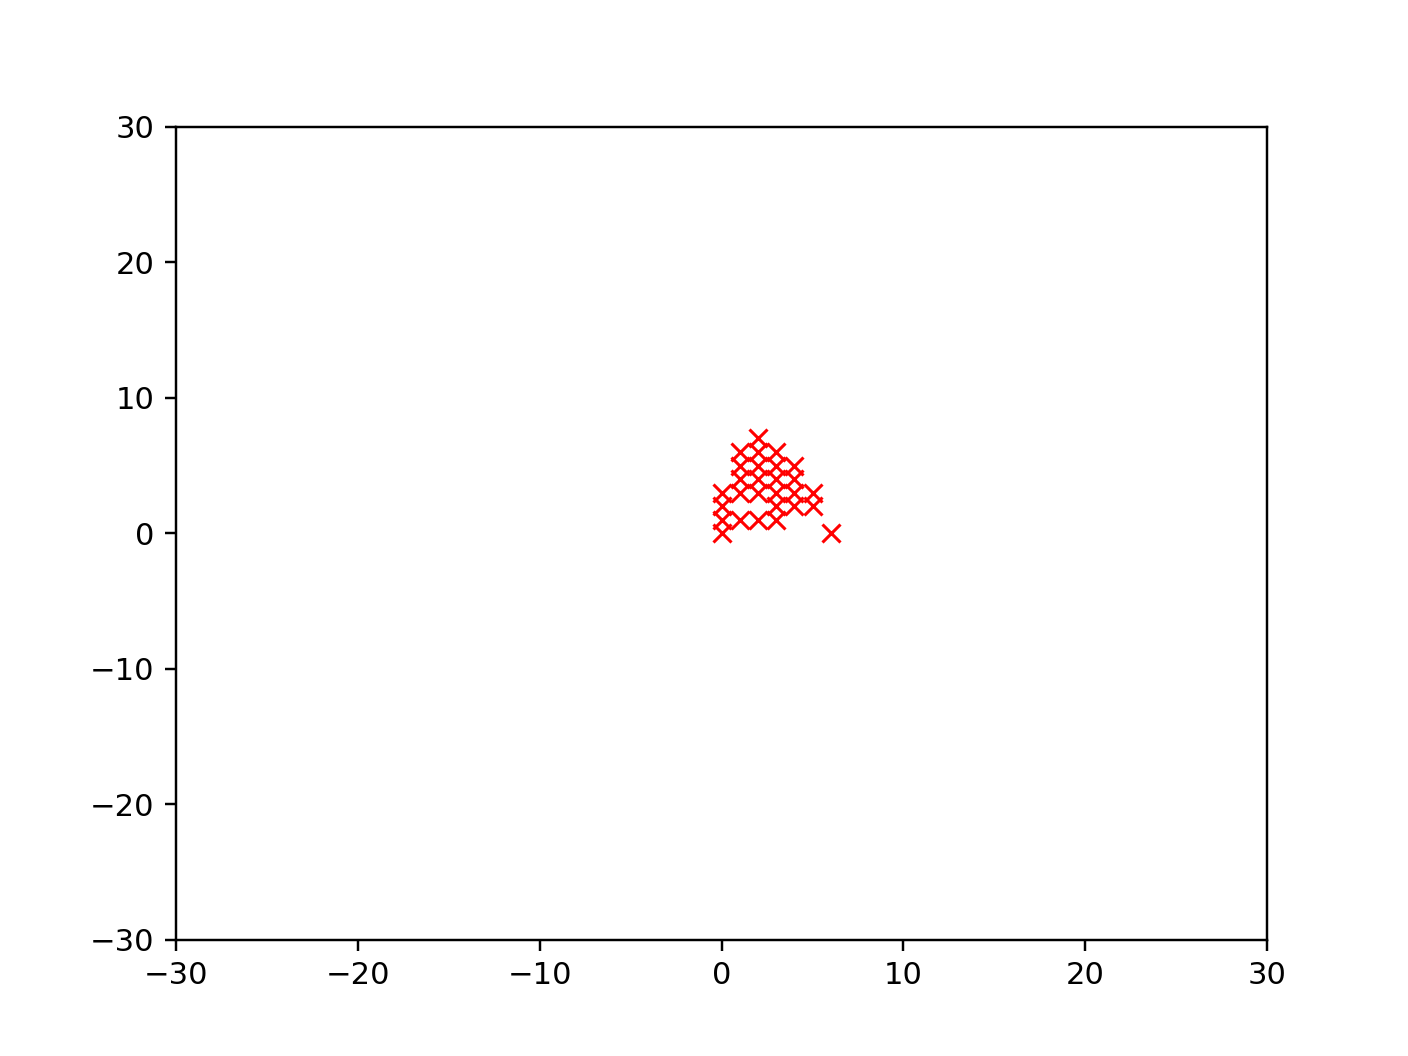

In [25]:
del model # Reset model just in case since we are running in a notebook

model = Model()
model.place_food(0.5) # Place food in all locations with probability p (we will remove this later, for now, get sim running)
timesteps = 50
for i in range(timesteps):
    model.add_ants(4) # Each ant starts at (0,0)
    model.move_ants() # Moves all ants in the room
positions = model.ants # The ant keeps track of its position and each ant has a list of its traveled positions. Positions is a list of all ants in the model.

# print(positions)
xdata = []
ydata = []
# plt.show() 
fig, ax = plt.subplots()
ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)
line, = ax.plot(xdata, ydata, 'rx') # A red mark for an ant
# axes.plot(xdata, ydata, 'rx')

for pos in positions:
    x, y = pos
    xdata.append(x)
    ydata.append(y)

# print(xdata)
# print(ydata)

def animate(frame_num):
    line.set_xdata(xdata[:frame_num])
    line.set_ydata(ydata[:frame_num])
    return line

anim = FuncAnimation(fig, animate, frames=timesteps, interval=200, repeat_delay=100)
plt.show()

# print(anim)
# plt.plot(xdata, ydata, 'rx')
# plt.show()
# for pos in positions:
#     x, y = pos
#     xdata.append(x)
#     ydata.append(y)
#     # line.set_xdata(xdata)
#     # line.set_ydata(ydata)
#     print("xdata: ", xdata)
#     print("ydata: ", ydata)
#     axes.plot(xdata, ydata, 'rx')
#     # plt.draw()
#     plt.pause(1)
#     time.sleep(0.005)
# plt.show()